In [1]:
import glob

In [2]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
import pandas as pd
import numpy as np
import numpy_indexed as npi
import scipy as sp
import matplotlib.pyplot as plt
import time
import visa
import datetime
from scipy.optimize import curve_fit

In [4]:
pwd

'/Users/APR1/Google Drive/COLUMBIA/S6/InterLab/radiometer/notebooks'

In [5]:
cd /Users/APR1/Google Drive/COLUMBIA/S6/InterLab/radiometer/Data/Calibration

/Users/APR1/Google Drive/COLUMBIA/S6/InterLab/radiometer/Data/Calibration


In [6]:
pwd

'/Users/APR1/Google Drive/COLUMBIA/S6/InterLab/radiometer/Data/Calibration'

In [7]:
tempUncert = 0.1
tempTimeUncert =0.5
tempFile = glob.glob("*.xlsx")
print(tempFile)
calibrationFile = glob.glob(tempFile[1][0:17]+"*.txt")
print(calibrationFile)
hotCalFile = '2016-11-18_16:29:45_Readout.txt'
dataDate = tempFile[0][0:10]
print(dataDate)

['2016-11-18_16-35-56_Temp.xlsx', '2016-11-18_16:35:56_Temp.xlsx']
['2016-11-18_16:35:56_Readout.txt']
2016-11-18


In [8]:
powerData = np.loadtxt(calibrationFile[0])
powerData[:,1] = -1000*powerData[:,1]
powerDataHot = np.loadtxt(hotCalFile)
powerDataHot[:,1] = -1000*powerDataHot[:,1]
#print(powerData[:,0])

In [9]:
tempData = pd.read_excel(tempFile[0], 'Sheet1', header=3)
tempData.head()
pattern = '%Y-%m-%d %H:%M:%S'
epoch = datetime.datetime.utcfromtimestamp(0)
tempTime = []
for t in tempData['Absolute time']:
    tempTime.append((t - epoch).total_seconds())
tempTime = [x-tempTime[0]+powerData[0,0] for x in tempTime]
tempArray = np.array([tempTime,tempData['Temperature in Kelvin']+20])

#print(tempArray[1,:])

In [10]:
#lowTempTimeError = [-0.5 for i in range(len(tempArray[0,:]))]
#highTempTimeError = [0.5 for i in range(len(tempArray[0,:]))]
#tempTimeError = [lowTempTimeError[:], highTempTimeError[:]]
#print(tempTimeError)
#lowTempError = [-0.5 for i in range(len(tempArray[1,:]))]
#highTempError = [0.5 for i in range(len(tempArray[1,:]))]
#tempError = [lowTempError, highTempError]
#print(tempError)
powerStd = np.std(powerData[:,1])/sqrt(len(powerData[:,1]))
print(powerStd)
#powerError = [[-powerStd for i in range(len(powerData[:,1]))],[powerStd for i in range(len(powerData[:,1]))]]
#print(powerError)

0.0427041116417


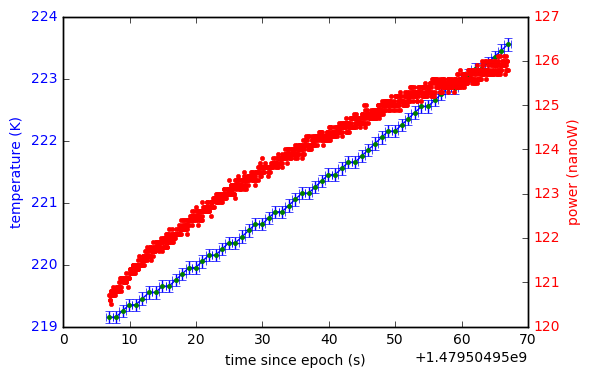

In [11]:
fig, ax1 = plt.subplots()
ax1.errorbar(tempArray[0,:],tempArray[1,:],xerr =tempTimeUncert ,yerr=tempUncert)
ax1.plot(tempArray[0,:],tempArray[1,:],'.')
ax1.set_xlabel('time since epoch (s)')
# Make the y-axis label and tick labels match the line color.
ax1.set_ylabel('temperature (K)', color='b')
for tl in ax1.get_yticklabels():
    tl.set_color('b')

ax2 = ax1.twinx()
#ax2.errorbar(powerData[:,0],powerData[:,1],yerr=powerStd,fmt='r.')
ax2.plot(powerData[:,0],powerData[:,1],'r.')
ax2.set_ylabel('power (nanoW)', color='r')
for tl in ax2.get_yticklabels():
    tl.set_color('r')
#plt.title('power (nanoW) and temperature measurement for dry ice calibration measurement with respect to time')
plt.savefig('../../Figures/power+temp_DryIce.png')
plt.show()

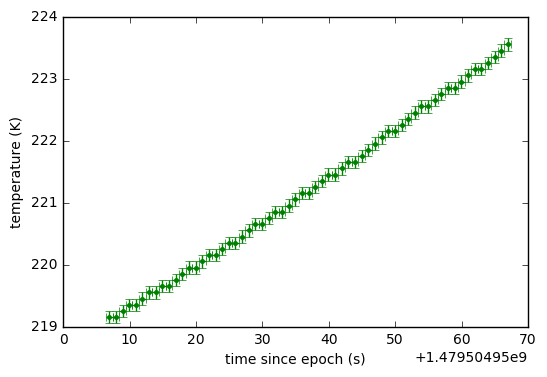

In [12]:
plt.errorbar(tempArray[0,:],tempArray[1,:],xerr = tempTimeUncert,yerr=tempUncert,fmt='g.')
#plt.plot(tempArray[0,:],tempArray[1,:],'.')
plt.xlabel('time since epoch (s)')
# Make the y-axis label and tick labels match the line color.
plt.ylabel('temperature (K)')
plt.savefig('../../Figures/temp_DryIce.png')
plt.show()

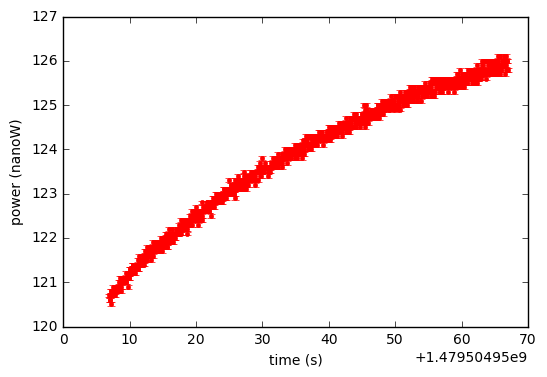

In [13]:
#plot(powerDataHot[:,0],powerDataHot[:,1],'*')
errorbar(powerData[:,0],powerData[:,1],yerr=powerStd,fmt='r.')
ylabel('power (nanoW)')
xlabel('time (s)')
plt.savefig('../../Figures/power_DryIce.png')
#print(powerData[:,0])

In [21]:
digitized = np.digitize(powerData[:,0],tempArray[0,:])
digitalize = np.digitize(powerData[:,0],tempArray[0,:])
powerSec = [powerData[digitized == i,1].mean() for i in range(1, len(tempArray[0,:]))]
powerSecStd = np.std(powerSec)/sqrt(len(powerSec))
print(powerSecStd)
#powerSecError = [[-powerSecStd for i in range(len(powerSec))],[powerSecStd for i in range(len(powerSec))]]
#print(powerSecError)

0.190160735254


219.15 120.738095238


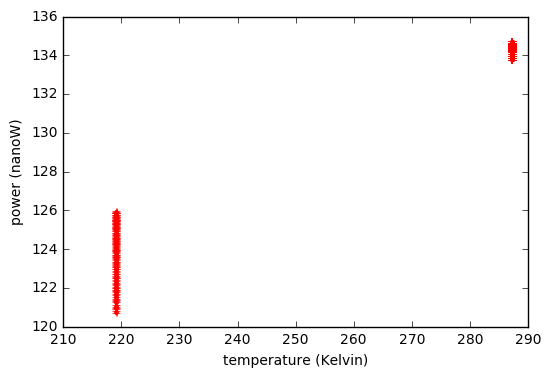

In [22]:
hotTemp = 14+273.15
temp = np.zeros(len(powerSec)+len(powerDataHot[:,1]))
power = np.zeros(len(powerSec)+len(powerDataHot[:,1]))
temp.fill(hotTemp)
temp[:len(powerSec)] = tempArray[1,:1]
#power.fill(0.65*1000)
power[:len(powerSec)] = powerSec[:]
power[len(powerSec):] = powerDataHot[:,1]
errorbar(temp,power,xerr=tempUncert,yerr=powerStd,fmt='r.')
ylabel('power (nanoW)')
xlabel('temperature (Kelvin)')
print(temp[0],power[0])

Only for cold temp G1=1.1329939262, T_rec1=-111.869327765


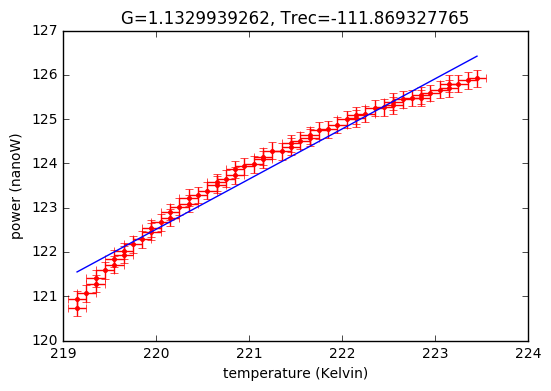

In [23]:
# choose the function to be fitted... 
def lin (x,a,b):
    return a*(x+b)

# ...and provide initial estimates for the parameters
a0,b0 = (0.005,90)

# exectute the curve fit...
linCoeffs, linFiterr = curve_fit(lin, temp, power, p0=(a0,b0))
G = linCoeffs[0]
Trec = linCoeffs[1]

# exectute the curve fit...
linCoeffs1, linFiterr1 = curve_fit(lin, tempArray[1,:-1], powerSec, p0=(a0,b0))
G1 = linCoeffs1[0]
Trec1 = linCoeffs1[1]

# ...and plot the results

# ...and plot the results
print ("Only for cold temp G1=%s, T_rec1=%s" % (G1,Trec1))
plt.errorbar(tempArray[1,:-1],powerSec,xerr=tempUncert,yerr=powerSecStd,fmt='r.')
plt.plot(tempArray[1,:-1],lin(tempArray[1,:-1],*linCoeffs1),'b')
plt.ylabel('power (nanoW)')
plt.xlabel('temperature (Kelvin)')
plt.title("G=%s, Trec=%s" % (G1,Trec1))
plt.savefig('../../Figures/power_DryIce+Fit.png')
plt.show()

Including hot temperature G=0.153144018261, T_rec=589.67826734


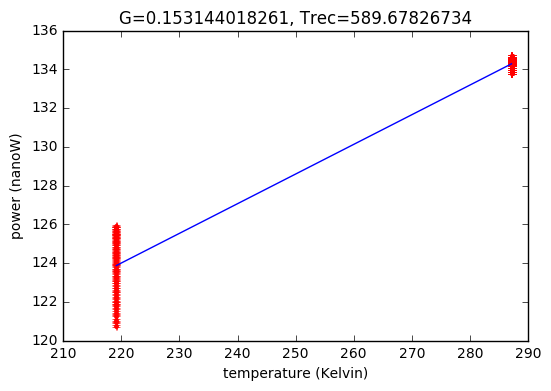

In [17]:
print ("Including hot temperature G=%s, T_rec=%s" % (linCoeffs[0], linCoeffs[1]))
plt.errorbar(temp,power,xerr = tempUncert,yerr=powerStd, fmt='r.')
plt.plot(temp,lin(temp,*linCoeffs),'b')
plt.ylabel('power (nanoW)')
plt.xlabel('temperature (Kelvin)')
plt.title("G=%s, Trec=%s" % (G,Trec))
savefig('../../Figures/power_DryIce+Hot_Fit.png')
plt.show()

In [42]:
Pnit= 78.5
Tnit = 3
Pcold = power[0]
Tcold = temp[0]
Phot = np.mean(powerDataHot[:,1])
Thot = 14+273.15
G = (Phot-Pcold)/(Thot-Tcold)
Trec = (Pcold * Thot - Phot * Tcold)/(Phot-Pcold)
print(G,Trec)
# exectute the curve fit...
linCoeffs, linFiterr = curve_fit(lin,[Tnit,Tcold, Thot] , [Pnit,Pcold,Phot], p0=(a0,b0))
G = linCoeffs[0]
Trec = linCoeffs[1]
print(G,Trec)

0.199160425677 387.085374462
0.196090771382 397.180122203


Including hot temperature G=0.196090771382, T_rec=397.180122203


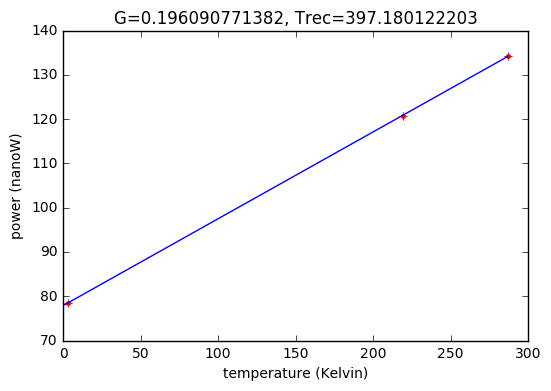

In [43]:
temperatures = linspace(Tnit-2,temp[-1],temp[-1]-Tnit+2)
print ("Including hot temperature G=%s, T_rec=%s" % (G, Trec))
plt.errorbar([Tnit,Tcold, Thot],[Pnit,Pcold,Phot],xerr = tempUncert,yerr=powerStd, fmt='r.')
plt.plot(temperatures,lin(temperatures,*[G,Trec]),'b')
plt.ylabel('power (nanoW)')
plt.xlabel('temperature (Kelvin)')
plt.title("G=%s, Trec=%s" % (G,Trec))
savefig('../../Figures/power_DryIce+Hot_Fit.png')
plt.show()